In [21]:
import numpy as np
import sys
sys.path.append('../src')
import matplotlib.pyplot as plt
from coupler import *
from scipy import interpolate

# Theory 
The transfer function of the 2x2 WDM (same fibre) is set for each mode as:


$$
\epsilon(f) = \frac{\pi}{n_{eff} c} \frac{\int{\left(n(r)^2 - n^2_{0}(r) \right) \left| E (r)\right|^{2} dr}}{\int{\left|E(r)\right|^2  dr }} \cdot f \cdot L = k \left(f\right) \cdot f \cdot L
$$



where f is the frequency and L the length of the fused stuff.

In [22]:
lmin = 1530e-9
lmax = 1560e-9
N_l = 10
a = 5e-6
N_points = 1024


lp1 = 1549e-9
lp2 = 1555e-9
ls = 1550e-9



In [23]:
F = abs(c/ls - c/lp1)
fpc, fbs = c/lp2 + F, c/lp2 - F
lpc, lbs = c/fpc, c/fbs

In [24]:
couple_obj = Coupling_coefficients(lmin, lmax, N_l, a, N_points)
couple_obj.fibre_calculate()

Maximum V number in space is 3.2501674851661546


In [25]:
d_vec_1 = [1.1e-6]#np.arange(0,10e-6, 0.1e-6)
d_vec_2 = [1.95e-6]

# WDM's

The model has 2 WDM's as usual. The first WDM is set to input both pumps and (fudged) the signal. The idea is that WDM1(lp1, ls) is fixed (with respect to length) with the p1 and signal and then the distance between the two fibres that form the coupler moves until p2 can be inputed through that WDM as well

The same thing happens with WDM2(BS/PC, lp2) but it is fixes such that to output BS and PC then d is changed until ls is transmitted in the fibre.

The inputs for d_vec here for both couplers are set as good ones from a visual minimisation on the problem.

In [26]:
k01_vec_1, k11_vec_1, couple01_vec = [], [], []
k01_vec_2, k11_vec_2, couple01_vec = [], [], []

for dd in d_vec_1:
    k01, k11, couple01, couple11 = couple_obj.create_coupling_coeff(dd)
    k01_vec_1.append(k01)
    k11_vec_1.append(k11)
    couple01_vec.append(couple01)
ratio_1 = [lp11k/ lp01k for lp01k, lp11k in zip(k01_vec_1, k11_vec_1)]

for dd in d_vec_2:
    k01, k11, couple01, couple11 = couple_obj.create_coupling_coeff(dd)
    k01_vec_2.append(k01)
    k11_vec_2.append(k11)
    #couple01_vec.append(couple01)
ratio_2 = [lp11k/ lp01k for lp01k, lp11k in zip(k01_vec_2, k11_vec_2)]

In [27]:
fp1, fp2, fs, fbs, fpc = (c/i for i in (lp1, lp2, ls, lbs, lpc))
fv = np.linspace(c/lmax, c/lmin, 2**14)

In [28]:
def plot(fv,co,c2, l1, l2, f, name = 'LP01'):
    f1, f2 = (1e-12*c/i for i in (l1, l2))

    f_pos = [np.argmin(abs(fv*1e-12 - fi)) for fi in (f1,f2)]
    if name == 'LP01':
        of_interest = np.abs(co[0][0])**2
    else:
        of_interest = np.abs(c2[0][0])**2
    fig = plt.figure(figsize = (10,5))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
    l1 = ax1.plot(fv*1e-12, np.abs(co[0][0])**2, label = 'LP01')
    l2 = ax1.plot(fv*1e-12, np.abs(c2[0][0])**2, label = 'LP11a')
    ax1.plot([f1], [of_interest[f_pos[0]]], 'o', markersize=6, color="red",
             label = r'$\lambda_1$ ('+str(100*of_interest[f_pos[0]])+')%')
    ax1.plot([f2], [of_interest[f_pos[1]]], 'o', markersize=6, color="green",
             label = r'$\lambda_2$ ('+str(100*of_interest[f_pos[1]])+')%')
    ax1.set_xlim([192.5, 194])
    ax1.set_xlabel(r'$f(THz)$')
    new_tick_locations = np.array(f[::-1])
    def tick_function(X):
        V = 1e-3*c/(X)
        return ["%.2f" % z for z in V]
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(tick_function(new_tick_locations))
    ax2.set_xlabel(r'$\lambda(nm)$')
    ax1.legend(loc = (1,0.71))
    plt.show()
    return None

In [29]:
def required_dist(k, f1, f2):
    return (pi/2) /  abs(k(f1) - k(f2))
def smr_coeff(z, kinter, fv, f1, f2):
    gv = kinter(fv) * z - kinter(f2)*z
    A = np.array([[np.sin(gv), 1j * np.cos(gv)], [1j * np.cos(gv), np.sin(gv)]])
    return A

In [30]:
def get_req_dist_WDM(l1, l2, k01, k11, fv, with_resp = 'LP01'):
    f1, f2 = (c/i for i in (l1,l2))
    kinter_lp01 = interpolate.interp1d(couple01.f_vec, k01, kind = 'cubic')
    kinter_lp11 = interpolate.interp1d(couple01.f_vec, k11, kind = 'cubic')
    if with_resp == 'LP01':
        coupling_distance = required_dist(kinter_lp01, f1, f2)
    else:
        coupling_distance = required_dist(kinter_lp11, f1, f2)
    co = smr_coeff(coupling_distance, kinter_lp01, fv, f1, f2)
    c2 = smr_coeff(coupling_distance, kinter_lp11, fv, f1, f2)
    return co, c2

# WDM1

In [31]:
l1,l2 = lp1, ls # set max min of port 1 to 3 for WDM1
l3,l4 = lbs, lp2 # set max min of port 1 to 3 for WDM2

In [41]:
lbs

1.5560077644572902e-06

In [32]:
f = [1e-12 * c/ i for i in (lp1,ls,lpc,lp2, lbs)]

Distance between fibres 1.10 um


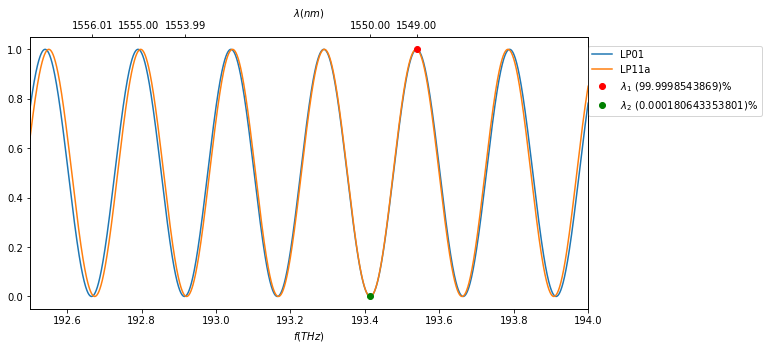

In [33]:
for dd,k01, k11 in zip(d_vec_1,k01_vec_1, k11_vec_1):
    clp01_1, clp11_1 = get_req_dist_WDM(l1,l2, k01, k11,fv, with_resp='LP01')
    print('Distance between fibres {:.2f} um'.format(dd*1e6))
    plot(fv,clp01_1,clp11_1, l1, l2,f)

# WDM2:

Distance between fibres 1.95 um


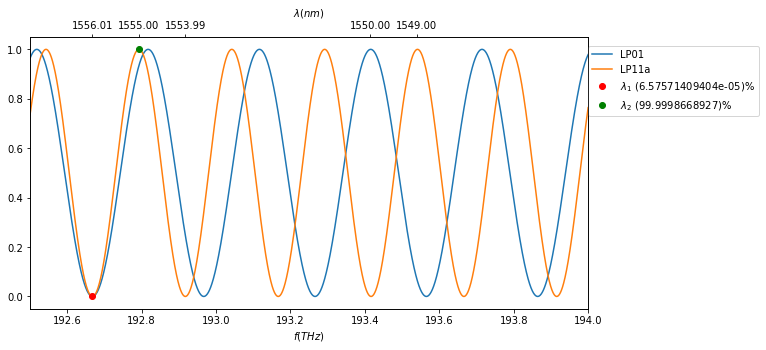

In [40]:
for dd,k01, k11 in zip(d_vec_2,k01_vec_2, k11_vec_2):
    clp01_2, clp11_2 = get_req_dist_WDM(l4,l3, k01, k11,fv, with_resp='LP11')
    print('Distance between fibres {:.2f} um'.format(dd*1e6))
    plot(fv,clp01_2,clp11_2, l3,l4,f, 'LP11')

# Transmitance windows
(With no splice loss assumed)

In [35]:
def plot_fopo_trans(tot_t, fv, f, name = 'LP01'):
    if name== 'LP01':
        i,j = 0,0
    else:
        i,j = 1, 2
    wave_labels = [r'$\lambda_{p1}$',r'$\lambda_{s}$', 
                   r'$\lambda_{PC}$',r'$\lambda_{p2}$', r'$\lambda_{BS}$']
    f_pos = [np.argmin(abs(fv*1e-12 - fi)) for fi in f]
    fig = plt.figure(figsize = (10,5))
    ax1 = fig.add_subplot(111)
    ax1.set_xlim([192.5, 194])
    ax2 = ax1.twiny()
    p1 = ax1.plot(fv*1e-12, tot_t[i], label = name)
    ax1.plot([f[j+0]], tot_t[i][f_pos[j]], 'o', markersize=6, color="red", label = wave_labels[j])
    ax1.plot([f[j+1]], tot_t[i][f_pos[j +1]], 'o', markersize=6, color="green", label = wave_labels[j+1])
    if name == 'LP11':
        ax1.plot([f[j+2]], tot_t[i][f_pos[j +2]], 'o', markersize=6, color="black", label = wave_labels[j+2])
    ax1.set_xlabel(r'$f(THz)$')
    new_tick_locations = np.array(f[::-1])
    def tick_function(X):
        V = 1e-3*c/(X)
        return ["%.1f" % z for z in V]
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(tick_function(new_tick_locations))
    ax2.set_xlabel(r'$\lambda(nm)$')
    ax1.legend(loc = (1,0.5))
    plt.show()
    return None

In [36]:
def db(x):
    return 10*np.log10(x)

def perc(l):
    return 100*10**(l/10)

def trans(clp01_1,clp01_2 ,clp11_1,clp11_2 ):
    tot_t = [perc(db(np.abs(clp01_1[0][1])**2) + db(np.abs(clp01_2[0][0])**2)), 
             perc(db(np.abs(clp11_1[0][1])**2) + db(np.abs(clp11_2[0][0])**2))]
    return tot_t

In [37]:
tot_t = trans(clp01_1,clp01_2 ,clp11_1,clp11_2 )

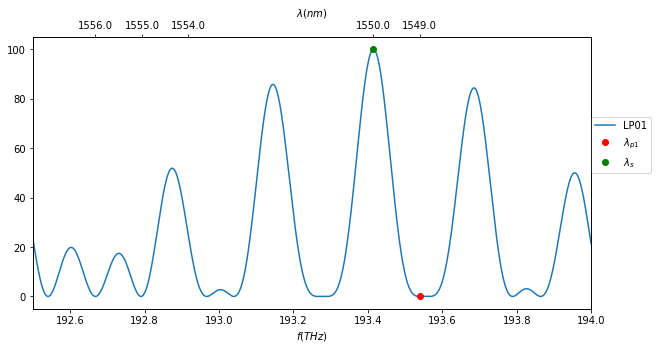

In [38]:
plot_fopo_trans(tot_t, fv, f)

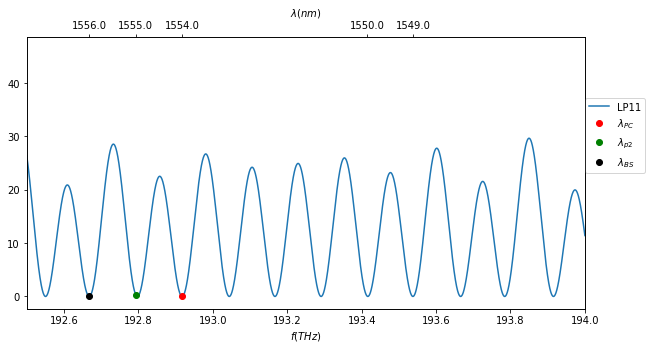

In [39]:
plot_fopo_trans(tot_t, fv, f, 'LP11')